This notebook implements supervised weights for approximating the solution to the one-dimensional Gross-Pitavskii equation.

# Import Libraries

In [1]:
%%capture
!pip install pytorch-optimizer
!git clone https://github.com/facebookresearch/optimizers.git
%cd optimizers
!pip install .
%cd ..

In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
import math
import numpy as np
import os
from torch.autograd import grad
from scipy.special import hermite
# from adabelief_pytorch import AdaBelief
from pytorch_optimizer import QHAdam, AdaHessian, Ranger21, SophiaH, Shampoo
from distributed_shampoo import AdamGraftingConfig, DistributedShampoo, DefaultEigenvalueCorrectedShampooConfig
from torch.optim.lr_scheduler import CosineAnnealingLR
import torch.nn.utils
import matplotlib.pyplot as plt

# Check if GPU is available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

print(device)

cuda


# Physics Informed Neural Network

In [3]:
class GrossPitaevskiiPINN(nn.Module):
    """
    Physics-Informed Neural Network (PINN) for solving the 1D Gross-Pitaevskii Equation.
    """

    def __init__(self, layers, hbar=1.0, m=1.0, g=100.0, mode=0, prev_prediction=None):
        """
        Parameters
        ----------
        layers : list of int
            Neural network architecture, each entry defines the number of neurons in that layer.
        hbar : float, optional
            Reduced Planck's constant (default is 1.0).
        m : float, optional
            Mass of the particle (default is 1.0).
        g : float, optional
            Interaction strength (default is 100.0).
        mode : int, optional
            Mode number (default is 0).
        prev_prediction : callable, optional
            A function representing the previous model's forward pass, used to incorporate past solutions
            when computing the current solution (default is None).
        """
        super().__init__()
        self.layers = layers
        self.network = self.build_network()
        self.g = g  # Interaction strength
        self.hbar = hbar  # Planck's constant, fixed
        self.m = m  # Particle mass, fixed
        self.mode = mode  # Mode number (n)

        # Trainable log-scale weights for adaptive balancing
        self.log_alpha = nn.Parameter(torch.zeros(5, dtype=torch.float32))

    def build_network(self):
        """
        Build the neural network with sine activation functions between layers.

        Returns
        -------
        nn.Sequential
            A PyTorch sequential model representing the neural network architecture.
        """
        layers = []
        for i in range(len(self.layers) - 1):
            layers.append(nn.Linear(self.layers[i], self.layers[i + 1]))
            if i < len(self.layers) - 2:
                layers.append(nn.Tanh())
        return nn.Sequential(*layers)

    def weighted_hermite(self, x, n):
        """
        Compute the weighted Hermite polynomial solution for the linear case (gamma = 0).
        Equation (34) in https://www.sciencedirect.com/science/article/abs/pii/S0010465513001318.

        Parameters
        ----------
        x : torch.Tensor
            Input tensor of spatial coordinates (collocation points) or boundary points.
        n : int
            Mode of ground state solution to Gross-Pitavskii equation (0 for base ground state)

        Returns
        -------
        torch.Tensor
            The weighted Hermite polynomial solution for the linear case (gamma = 0).
        """
        H_n = hermite(n)(x.cpu().detach().numpy())  # Hermite polynomial evaluated at x
        norm_factor = (2**n * math.factorial(n) * np.sqrt(np.pi))**(-0.5)
        weighted_hermite = norm_factor * torch.exp(-x**2 / 2) * torch.tensor(H_n, dtype=torch.float32).to(device)

        return weighted_hermite

    def forward(self, inputs):
        """
        Forward pass through the neural network.

        Parameters
        ----------
        inputs : torch.Tensor
            Input tensor containing spatial points (collocation points).

        Returns
        -------
        torch.Tensor
            Output tensor representing the predicted solution.
        """
        return self.network(inputs)

    def compute_potential(self, x, potential_type="harmonic", **kwargs):
        """
        Compute a symmetric or asymmetric potential function for the 1D domain.

        Parameters
        ----------
        x : torch.Tensor
            Input tensor of spatial coordinates.
        potential_type : str, optional
            Type of potential. Options are: "harmonic".
        kwargs : dict
            Additional parameters specific to each potential type.

        Returns
        -------
        V : torch.Tensor
            Tensor of potential values at the input points.

        Raises
        ------
        ValueError
            If the potential type is not recognized.
        """
        if potential_type == "harmonic":
            omega = kwargs.get('omega', 1.0)  # Frequency for harmonic potential
            V = 0.5 * omega ** 2 * x ** 2
        elif potential_type == "gaussian":
            a = kwargs.get('a', 0.0)  # Center of the Gaussian
            V = torch.exp(-(x - a) ** 2)
        elif potential_type == "periodic":
            V0 = kwargs.get('V0', 1.0)  # Depth of the potential
            k = kwargs.get('k', 2 * np.pi / 5.0)  # Wave number for periodic potential
            V = V0 * torch.cos(k * x) ** 2
        else:
            raise ValueError(f"Unknown potential type: {potential_type}")

        return V

    def compute_thomas_fermi_approx(self, lambda_pde, potential, eta):
        """
        Calculate the Thomas–Fermi approximation for the given potential.

        Parameters
        ----------
        lambda_pde : float
            Eigenvalue from lowest enegry ground state.
        potential : torch.Tensor
            Potential values corresponding to the spatial coordinates.
        eta : float
            Interaction strength.

        Returns
        -------
        torch.Tensor
            Thomas–Fermi approximation of the wave function.
        """
        tf_approx = torch.sqrt(torch.relu((lambda_pde - potential) / eta))
        return tf_approx

    def boundary_loss(self, boundary_points, boundary_values, prev_prediction=None):
        """
        Compute the boundary loss (MSE) for the boundary conditions.

        Parameters
        ----------
        boundary_points : torch.Tensor
            Input tensor of boundary spatial points.
        boundary_values : torch.Tensor
            Tensor of boundary values (for Dirichlet conditions).
        prev_prediction : GrossPitaevskiiPINN or None
            Previously trained model whose predictions are used as part of the training process.
            If None, the model starts training from scratch.

        Returns
        -------
        torch.Tensor
            Mean squared error (MSE) at the boundary points.
        """
        u_pred = self.forward(boundary_points)

        if prev_prediction is None:
            u = self.weighted_hermite(boundary_points, self.mode) + u_pred
        else:
            u = prev_prediction(boundary_points) + u_pred  # Use model’s output from previous eta

        return torch.mean((u - boundary_values) ** 2)

    def riesz_loss(self, predictions, inputs, eta, potential_type, precomputed_potential=None, prev_prediction=None):
        """
        Compute the Riesz energy loss for the Gross-Pitaevskii equation.

        Parameters
        ----------
        predictions : torch.Tensor
            Predicted solution from the network.
        inputs : torch.Tensor
            Input tensor of spatial coordinates (collocation points).
        eta : float
            Interaction strength.
        potential_type : str
            Type of potential function to use.
        precomputed_potential : torch.Tensor
            Precomputed potential. Default is None.
        prev_prediction : GrossPitaevskiiPINN or None
            Previously trained model whose predictions are used as part of the training process.
            If None, the model starts training from scratch.

        Returns
        -------
        torch.Tensor
            Riesz energy loss value.
        """
        if prev_prediction is None:
            u = self.weighted_hermite(inputs, self.mode) + predictions
        else:
            scaling_factor = torch.sqrt(torch.tensor(eta, dtype=torch.float32, device=device))
            u = prev_prediction(inputs) + predictions  # Use model’s output from previous eta

        if not inputs.requires_grad:
            inputs = inputs.clone().detach().requires_grad_(True)
        u_x = torch.autograd.grad(outputs=u, inputs=inputs,
                                  grad_outputs=torch.ones_like(predictions),
                                  create_graph=True, retain_graph=True)[0]

        laplacian_term = torch.mean(u_x ** 2)  # Kinetic term
        if precomputed_potential is not None:
            V = precomputed_potential
        else:
            V = self.compute_potential(inputs, potential_type)
        potential_term = torch.mean(V * u ** 2)  # Potential term
        interaction_term = 0.5 * eta * torch.mean(u ** 4)  # Interaction term

        riesz_energy = 0.5 * (laplacian_term + potential_term + interaction_term)

        return riesz_energy

    def pde_loss(self, inputs, predictions, eta, potential_type, precomputed_potential=None, prev_prediction=None):
        """
        Compute the PDE loss for the Gross-Pitaevskii equation.

        Parameters
        ----------
        inputs : torch.Tensor
            Input tensor of spatial coordinates (collocation points).
        predictions : torch.Tensor
            Predicted solution from the network.
        eta : float
            Interaction strength.
        potential_type : str
            Type of potential function to use.
        precomputed_potential : torch.Tensor
            Precomputed potential. Default is None.
        prev_prediction : GrossPitaevskiiPINN or None
            Previously trained model whose predictions are used as part of the training process.
            If None, the model starts training from scratch.

        Returns
        -------
        tuple
            Tuple containing:
                - torch.Tensor: PDE loss value.
                - torch.Tensor: PDE residual.
                - torch.Tensor: Smallest eigenvalue (lambda).
        """
        if prev_prediction is None:
            u = self.weighted_hermite(inputs, self.mode) + predictions
        else:
            scaling_factor = torch.sqrt(torch.tensor(eta, dtype=torch.float32, device=device))
            u = prev_prediction(inputs) + predictions # Use model’s output from previous eta

        # Compute first and second derivatives with respect to x
        u_x = grad(u, inputs, grad_outputs=torch.ones_like(u), create_graph=True)[0]
        u_xx = grad(u_x, inputs, grad_outputs=torch.ones_like(u_x), create_graph=True)[0]

        # Compute λ from the energy functional
        if precomputed_potential is not None:
            V = precomputed_potential
        else:
            V = self.compute_potential(inputs, potential_type)
        lambda_pde = torch.mean(u_x ** 2 + V * u ** 2 + eta * u ** 4) / torch.mean(u ** 2)

        # Residual of the 1D Gross-Pitaevskii equation
        if precomputed_potential is not None:
            V = precomputed_potential
        else:
            V = self.compute_potential(inputs, potential_type)
        pde_residual = -u_xx + V * u + eta * torch.abs(u ** 2) * u - lambda_pde * u

        # Regularization: See https://arxiv.org/abs/2010.05075

        # Term 1: L_f = 1 / (f(x, λ))^2, penalizes the network if the PDE residual is close to zero to avoid trivial eigenfunctions
        L_f = 1 / (torch.mean(u ** 2) + 1e-2)

        # Term 2: L_λ = 1 / λ^2, penalizes small eigenvalues λ, ensuring non-trivial eigenvalues
        L_lambda = 1 / (lambda_pde ** 2 + 1e-6)

        # Term 3: L_drive = e^(-λ + c), encourages λ to grow, preventing collapse to small values
        L_drive = torch.exp(-lambda_pde + 1.0)

        # PDE loss (residual plus regularization terms)
        pde_loss = torch.mean(pde_residual ** 2)  #+ L_lambda + L_f

        return pde_loss, pde_residual, lambda_pde

    def symmetry_loss(self, collocation_points, lb, ub):
        """
        Compute the symmetry loss to enforce u(x) = u((a+b)-x).

        Parameters
        ----------
        collocation_points : torch.Tensor
            Tensor of interior spatial points.
        lb : torch.Tensor
            Lower bound of interval.
        ub: torch.Tensor
            Upper bound of interval.

        Returns
        -------
        sym_loss : torch.Tensor
            The mean squared error enforcing symmetry u(x) = u((a+b)-x).
        """
        # Reflect points across the center of the domain
        x_reflected = (lb + ub) - collocation_points

        # Evaluate u(x) and u((a+b)-x)
        u_original = self.forward(collocation_points)
        u_reflected = self.forward(x_reflected)

        # Compute MSE to enforce symmetry
        sym_loss = torch.mean((u_original - u_reflected) ** 2)
        return sym_loss

    def total_loss(self, collocation_points, boundary_points, boundary_values, eta, lb, ub, weights, potential_type,
                   precomputed_potential=None, prev_prediction=None):
        """
        Compute the total loss combining multiple loss terms with self-adaptive weight balancing.

        Parameters
        ----------
        collocation_points : torch.Tensor
            Tensor of spatial coordinates for interior points.
        boundary_points : torch.Tensor
            Tensor of spatial coordinates at domain boundaries.
        boundary_values : torch.Tensor
            Expected function values at boundary points (Dirichlet conditions).
        eta : float
            Interaction strength parameter.
        lb : torch.Tensor
            Lower bound of the spatial domain.
        ub : torch.Tensor
            Upper bound of the spatial domain.
        potential_type : str
            Type of potential function used in the PDE.
        precomputed_potential : torch.Tensor, optional
            Precomputed potential values for efficiency (default: None, computed dynamically).
        prev_prediction : GrossPitaevskiiPINN, optional
            A previously trained model to incorporate past solutions (default: None).

        Returns
        -------
        total_loss : torch.Tensor
            Combined loss value weighted by dynamically learned coefficients.
        data_loss : torch.Tensor
            Loss enforcing boundary conditions.
        riesz_energy_loss : torch.Tensor
            Loss based on the Riesz energy formulation.
        pde_loss : torch.Tensor
            Loss from the PDE residual enforcement.
        norm_loss : torch.Tensor
            Regularization loss ensuring wave function normalization.
        sym_loss : torch.Tensor
            Loss enforcing domain symmetry.
        alpha : torch.Tensor
            Adaptive weights for balancing individual loss terms.
        """

        # Use precomputed potential if provided
        if precomputed_potential is not None:
            V = precomputed_potential
        else:
            V = self.compute_potential(collocation_points, potential_type)

        # Compute individual loss components
        data_loss = self.boundary_loss(boundary_points, boundary_values, prev_prediction)
        riesz_energy_loss = self.riesz_loss(self.forward(collocation_points), collocation_points, eta, potential_type,V, prev_prediction)
        pde_loss, _, _ = self.pde_loss(collocation_points, self.forward(collocation_points), eta, potential_type, V, prev_prediction)
        norm_loss = (torch.norm(self.forward(collocation_points), p=2) - 1) ** 2
        sym_loss = self.symmetry_loss(collocation_points, lb, ub)

        # Compute self-adaptive weights
        alpha = torch.exp(self.log_alpha)

        # Scaling factor for pde loss and riesz energy loss
        domain_length = ub - lb

        # Compute weighted losses and total loss
        losses = [data_loss, riesz_energy_loss  / domain_length, pde_loss / domain_length, norm_loss, sym_loss]
        weighted_losses = [weights[i] * alpha[i] * loss for i, loss in enumerate(losses)]
        #weighted_losses = [alpha[i] * losses[i] for i in range(len(losses))]
        total_loss = sum(weighted_losses)

        return total_loss, data_loss, riesz_energy_loss, pde_loss, norm_loss, sym_loss, alpha

# Initialize Weights

In [4]:
def initialize_weights(m):
    """
    Initialize the weights of the neural network layers using Xavier uniform initialization.

    Parameters
    ----------
    m : torch.nn.Module
        A layer of the neural network. If it is a linear layer, its weights and biases are initialized.
    """
    if isinstance(m, nn.Linear):
        nn.init.xavier_uniform_(m.weight)
        m.bias.data.fill_(0.01)

# Prepare Training Data

In [5]:
def prepare_training_data(N_u, N_f, lb, ub):
    """
    Prepare boundary and collocation points for training.

    Parameters
    ----------
    N_u : int
        Number of boundary points.
    N_f : int
        Number of collocation points.
    lb : np.ndarray
        Lower bounds of the domain.
    ub : np.ndarray
        Upper bounds of the domain.

    Returns
    -------
    collocation_points : np.ndarray
        Collocation points.
    boundary_points : np.ndarray
        Boundary points.
    boundary_values : np.ndarray
        Boundary values.
    """

    # Boundary of interval
    boundary_points = np.array([[lb], [ub]])
    boundary_values = np.zeros((2, 1))

    # Dynamically sample points inside the interval
    collocation_points = np.random.rand(N_f, 1) * (ub - lb) + lb

    return collocation_points, boundary_points, boundary_values

# Train PINN with Optimizer

In [6]:
def train_pinn_with_optimizer(X, N_u, N_f, layers, eta, epochs, lb, ub, weights, model_save_path, potential_type,
                              prev_prediction, optimizer_name):
    """
    Train the Physics-Informed Neural Network (PINN) for the 1D Gross-Pitaevskii equation.

    Parameters
    ----------
    X : np.ndarray
        Input data for the neural network
    N_u : int
        Number of boundary points
    N_f : int
        Number of collocation points (interior points) for the physics-based loss
    layers : list of int
        Architecture of the neural network
    eta : float
        Interaction strength
    epochs: int
        Number of epochs
    lb : int
        Lower bound of interval.
    ub : int
        Upper bound of interval.
    weights : list
        Weights for different loss terms.
    model_save_path : str
        Save path for trained model
    potential_type: str
        Type of potential function to use
    prev_prediction : GrossPitaevskiiPINN or None
        Previously trained model whose predictions are used as part of the training process.
        If None, the model starts training from scratch.
    optimizer_name : str
        Name of optimizer to train.

    Returns
    -------
    model : GrossPitaevskiiPINN
        The trained model
    loss_history : list of float
        List of loss values recorded during training for the specific optimizer.
    lambda_pde_history : list of float
        List of λ_PDE values recorded during training for the specific optimizer.
    """
    # Instantiate the PINN model for each optimizer and initialize its weights
    model = GrossPitaevskiiPINN(layers).to(device)
    model.apply(initialize_weights)

    # Select the optimizer
    optimizers = {
        "Adam": optim.Adam(model.parameters(), lr=1e-3),
        "Shampoo": DistributedShampoo( model.parameters(),
                                       lr=0.001,
                                       betas=(0.9, 0.999),
                                       epsilon=1e-12,
                                       weight_decay=1e-05,
                                       max_preconditioner_dim=8192,
                                       start_preconditioning_step=100,
                                       precondition_frequency=100,
                                       use_decoupled_weight_decay=False,
                                       grafting_config=AdamGraftingConfig(beta2=0.999,epsilon=1e-08),
                                       ),
        "Shampoo-Eigen": DistributedShampoo(model.parameters(),
                                      lr=0.001,
                                      betas=(0.9, 0.999),
                                      epsilon=1e-12,
                                      weight_decay=1e-05,
                                      max_preconditioner_dim=8192,
                                      start_preconditioning_step=100,
                                      precondition_frequency=100,
                                      use_decoupled_weight_decay=True,
                                      # This can also be set to `DefaultSOAPConfig` which uses QR decompositions, hence is
                                      # less expensive and might thereby allow for a smaller `precondition_frequency`.
                                      preconditioner_config=DefaultEigenvalueCorrectedShampooConfig
                                      )

    }

    optimizer = optimizers[optimizer_name]
    # scheduler = optim.lr_scheduler.OneCycleLR(optimizer, max_lr=1e-3, steps_per_epoch=epochs // 10, epochs=epochs)
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, patience=25, factor=0.5, verbose=True)

    # Prepare training data (collocation and boundary points)
    collocation_points, boundary_points, boundary_values = prepare_training_data(N_u, N_f, lb, ub)

    # Convert data to PyTorch tensors and move to device
    collocation_points_tensor = torch.tensor(collocation_points, dtype=torch.float32, requires_grad=True).to(device)
    boundary_points_tensor = torch.tensor(boundary_points, dtype=torch.float32).to(device)
    boundary_values_tensor = torch.tensor(boundary_values, dtype=torch.float32).to(device)
    lb_tensor = torch.tensor(lb, dtype=torch.float32).to(device)
    ub_tensor = torch.tensor(ub, dtype=torch.float32).to(device)

    # Precompute potential
    V = model.compute_potential(collocation_points_tensor, potential_type).detach()
    V.requires_grad = False

    # Precompute Thomas-Fermi approximation
    #tf_approx = model.compute_thomas_fermi_approx(collocation_points_tensor, V, eta).detach()
    #tf_approx.requires_grad = False

    loss_history = []
    lambda_pde_history = []

    for epoch in range(epochs):
        model.train()
        optimizer.zero_grad()

        # Calculate the total loss (boundary, Riesz energy, PDE, normalization, and symmetry losses)
        # with precomputed potential and Thomas-Fermi approximation
        loss, data_loss, riesz_energy_loss, pde_loss, norm_loss, sym_loss, alpha = model.total_loss(collocation_points_tensor,
                                                                              boundary_points_tensor,
                                                                              boundary_values_tensor,
                                                                              eta,
                                                                              lb_tensor, ub_tensor,
                                                                              weights, potential_type, V,
                                                                              prev_prediction)

        # Backpropagation and optimization
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        #torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=2.0, norm_type=2)
        optimizer.step()
        scheduler.step(loss)

        # Record the total loss and lambda_pde every 100 epochs
        if epoch % 100 == 0:
            _, _, lambda_pde = model.pde_loss(
                collocation_points_tensor, model.forward(collocation_points_tensor),
                eta, potential_type, V, prev_prediction
            )
            loss_history.append(loss.item())
            lambda_pde_history.append(lambda_pde.detach().cpu().item())

        # Compute λ_PDE, η, and loss every 1,000 epochs
        if epoch % 1000 == 0:
            _, _, lambda_pde = model.pde_loss(
                collocation_points_tensor, model.forward(collocation_points_tensor),
                eta, potential_type, V, prev_prediction
            )
            print(f"[{optimizer_name}] Epoch [{epoch}/{epochs}]: η = {eta}, λ_PDE = {lambda_pde.item():.6f},  Loss: {loss.item():.6f}, "
                  f"Data Loss = {data_loss.item():.6f}, Riesz Loss = {riesz_energy_loss.item():.6f}, "
                  f"PDE Loss = {pde_loss.item():.6f}, Norm Loss = {norm_loss.item():.6f}, "
                  f"Sym Loss = {sym_loss.item():.6f}, Adaptive Weights: {alpha.tolist()}")

    return model, loss_history, lambda_pde_history

# Normalize Wave Function


In [7]:
def normalize_wave_function(u):
    """
    Normalize the wave function with respect to its maximum value.

    Parameters
    ----------
    u : torch.Tensor
        The predicted wave function.

    Returns
    -------
    torch.Tensor
        The normalized wave function.
    """
    return np.abs(u) / np.max(np.abs(u))

# Plot Potential

In [8]:
def plot_potential_1D(X_test, potential):
    """
    Plot the 1D potential function.

    Parameters
    ----------
    X_test : np.ndarray
        The test points where the potential is computed.
    potential : np.ndarray
        The computed potential values at the test points.
    """
    plt.figure(figsize=(6, 5))

    # X_test is the x-values (positions) of the 1D potential
    plt.plot(X_test, potential, label='Potential $V(x)$', color='green')

    plt.title('Potential $V(x)$ in 1D')
    plt.xlabel('$x$')
    plt.ylabel('$V(x)$')
    plt.grid(True)
    plt.legend()
    plt.show()

# Train and Save PINN

In [9]:
def train_and_save_pinn(X, N_u, N_f, layers, eta, epochs, lb, ub, weights, model_save_path, potential_type,
                        prev_model, optimizer_name):
    """
    Train the Physics-Informed Neural Network (PINN) model and save it.

    This function trains a PINN model for the 1D Gross-Pitaevskii equation with a specific interaction
    strength (eta) and saves the trained model to a specified path. It also returns the trained model
    and the loss history recorded during training.

    Parameters
    ----------
    X : np.ndarray
        Input data for the training (e.g., spatial domain points).
    N_u : int
        Number of boundary points.
    N_f : int
        Number of collocation points (interior points) for physics-based loss.
    layers : list of int
        Architecture of the neural network, defined as a list of layer sizes.
        For example, [1, 100, 100, 100, 1] represents an input layer with 1 neuron,
        three hidden layers with 20 neurons each, and an output layer with 1 neuron.
    eta : float
        Interaction strength parameter for the Gross-Pitaevskii equation.
    epochs : int
        Number of training epochs.
    lb : int
        Lower bound of interval.
    ub : int
        Upper bound of interval.
    weights : list
        Weights for different loss terms.
    model_save_path : str
        File name to save the trained model weights (e.g., 'model_eta_1.pth').
    potential_type: str
        Type of potential function to use
    prev_model : GrossPitaevskiiPINN or None
        Previously trained model whose predictions are used as part of the training process.
        If None, the model starts training from scratch.
    optimizer_name : str
        Name of optimizer.

    Returns
    -------
    model : GrossPitaevskiiPINN
        The trained PINN model.
    loss_history : dict of (eta, optimizer) -> list of float
        A dictionary where each key is a tuple (eta, optimizer name) and
        the corresponding value is a list of loss values recorded during training.
    lambda_pde_history : dict of (eta, optimizer) -> list of float
        A dictionary where each key is a tuple (eta, optimizer name) and
        the corresponding value is a list of λ_PDE values recorded during training.
    """

    # Create a new model, passing the previous model's forward function if available
    prev_prediction = prev_model.forward if prev_model is not None else None
    if prev_model is not None:
        prev_model.eval()
    model = GrossPitaevskiiPINN(layers, prev_prediction=prev_prediction).to(device)
    model.apply(initialize_weights)

    # Train the model
    model, loss_history, lambda_pde_history = train_pinn_with_optimizer(X, N_u=N_u, N_f=N_f, layers=layers, eta=eta,
                                      epochs=epochs, lb=lb, ub=ub, weights=weights, model_save_path=model_save_path,
                                      potential_type=potential_type, prev_prediction=prev_prediction,
                                      optimizer_name=optimizer_name)

    # Directory to save the models
    model_save_dir = 'models'
    os.makedirs(model_save_dir, exist_ok=True)  # Create the directory if it doesn't exist

    # Save model after training
    save_model_path = os.path.join(model_save_dir, model_save_path)
    torch.save(model.state_dict(), save_model_path)  # Save model weights

    return model, loss_history, lambda_pde_history

# Predict and Plot

In [10]:
def predict_and_plot(models, etas, optimizers, X_test, save_path='plots/predicted_solutions.png',
                     potential_type='gaussian', prev_prediction=None):
    """
    Predict and plot the solutions for all models, making separate plots for each optimizer.

    Parameters
    ----------
    models : dict
        A dictionary where keys are η values, and values are dictionaries mapping optimizer names to trained models.
        Example: models[eta][optimizer_name] -> model
    etas : list of float
        A list of η values used during training.
    optimizers : list of str
        A list of optimizer names used during training.
    X_test : np.ndarray
        Test points along the 1D interval.
    save_path : str, optional
        The path template to save the plot image (default is 'plots/predicted_solutions_{optimizer}.png').
    potential_type : str, optional
        Type of potential function to use. Default is 'gaussian'.
    prev_prediction : callable, optional
        A function representing the previous model's forward pass.

    Returns
    -------
    None
    """
    # Ensure the plots directory exists
    os.makedirs(os.path.dirname(save_path), exist_ok=True)

    for optimizer_name in optimizers:
        plt.figure(figsize=(10, 6))

        for eta in etas:
            if eta in models and optimizer_name in models[eta]:
                model = models[eta][optimizer_name]  # Retrieve model for optimizer and eta
                model.eval()

                # Prepare test data
                X_test_tensor = torch.tensor(X_test, dtype=torch.float32, requires_grad=True).to(device)
                u_pred = model(X_test_tensor).detach().cpu().numpy()
                u_pred_normalized = normalize_wave_function(u_pred)

                # Calculate the potential
                potential = model.compute_potential(X_test_tensor, potential_type)

                # Calculate λ_PDE and the Thomas-Fermi approximation
                _, _, lambda_pde = model.pde_loss(X_test_tensor,
                                                  model.forward(X_test_tensor), eta,
                                                  potential_type, potential, prev_prediction)
                tf_approx = model.compute_thomas_fermi_approx(X_test_tensor, potential, eta).detach().cpu().numpy()
                tf_approx_normalized = normalize_wave_function(tf_approx)

                # Plot predicted solution for this optimizer
                plt.plot(X_test, u_pred_normalized, label=f"η={eta}", linestyle="-")

        # Plot Weighted Hermite Approximation (η=0)
        wh_approx = model.weighted_hermite(X_test_tensor, 0).detach().cpu().numpy()
        wh_approx_normalized = normalize_wave_function(wh_approx)
        plt.plot(X_test, wh_approx_normalized, linestyle="--", color="black",
                 label="Weighted Hermite (η=0)")

        plt.title(f"PINN Solutions - {potential_type.capitalize()} - {optimizer_name}", fontsize="xx-large")
        plt.xlabel("$x$", fontsize="xx-large")
        plt.ylabel("Normalized $u(x)$", fontsize="xx-large")
        plt.grid(True)
        plt.legend(fontsize="large")

        # Set tick sizes
        plt.xticks(fontsize="x-large")
        plt.yticks(fontsize="x-large")

        # Save the plot for this optimizer
        optimizer_plot_path = save_path.format(optimizer=optimizer_name, potential_type=potential_type)
        plt.savefig(optimizer_plot_path, dpi=300, bbox_inches='tight')
        plt.show()

# Plot Loss History

In [11]:
def plot_loss_history(loss_histories, etas, optimizer_names, save_path='plots/loss_history.png', potential_type='gaussian'):
    """
    Plot the training loss history for all optimizers and interaction strengths (etas) in a single plot.

    Parameters
    ----------
    loss_histories : dict
        Dictionary where keys are eta values, and values are dictionaries mapping optimizer names to loss history lists.
    etas : list of float
        List of eta values used in training.
    optimizer_names : list of str
        List of optimizer names used during training.
    save_path : str, optional
        File path to save the plot, by default 'plots/loss_history.png'.
    potential_type : str, optional
        Type of potential function to use. Default is 'gaussian'.

    Returns
    -------
    None
    """

    # Ensure the plots directory exists
    os.makedirs(os.path.dirname(save_path), exist_ok=True)

    plt.figure(figsize=(10, 6))

    for optimizer_name in optimizer_names:
        for eta in etas:
            if eta in loss_histories and optimizer_name in loss_histories[eta]:
                loss = loss_histories[eta][optimizer_name]
                plt.plot(np.arange(len(loss)), loss, marker='o', label=f"{optimizer_name}, η={eta}")

    plt.xlabel('Training step (x 100)', fontsize="xx-large")
    plt.ylabel('Total Loss', fontsize="xx-large")
    plt.yscale('log')
    plt.title(f'Loss History for Different Interaction Strengths ($\\eta$) for {potential_type.capitalize()} Potential',
              fontsize="xx-large")
    plt.legend(fontsize="large")
    plt.grid(True)

    # Set larger tick sizes
    plt.xticks(fontsize="x-large")
    plt.yticks(fontsize="x-large")

    # Save the plot
    save_path = save_path.format(potential_type=potential_type)
    plt.savefig(save_path, dpi=300, bbox_inches='tight')
    plt.show()

# Plot Lambda PDE

In [12]:
def plot_lambda_pde(lambda_pde_histories, etas, optimizer_names, save_path="plots/lambda_pde.png", potential_type="harmonic"):
    """
    Plot the evolution of λ_PDE over training iterations for all optimizers and interaction strengths in one figure.

    Parameters
    ----------
    lambda_pde_histories : dict
        Dictionary where keys are eta values, and values are dictionaries mapping optimizer names to lambda_pde history lists.
    etas : list of float
        List of eta values used in training.
    optimizer_names : list of str
        List of optimizer names used during training.
    save_path : str, optional
        File path to save the plot, by default 'plots/lambda_pde.png'.
    potential_type : str, optional
        Type of potential function to use. Default is 'gaussian'.

    Returns
    -------
    None
    """

    # Ensure the plots directory exists
    os.makedirs(os.path.dirname(save_path), exist_ok=True)

    plt.figure(figsize=(10, 6))

    for optimizer_name in optimizer_names:
        for eta in etas:
            if eta in lambda_pde_histories and optimizer_name in lambda_pde_histories[eta]:
                lambda_pde = lambda_pde_histories[eta][optimizer_name]
                plt.plot(np.arange(len(lambda_pde)), lambda_pde, marker='o', label=f"{optimizer_name}, η={eta}")

    plt.xlabel('Training step (x 100)', fontsize="xx-large")
    plt.ylabel(r"$\lambda_{PDE}$", fontsize="xx-large")
    plt.title(
        r"$\lambda_{PDE}$ for Different Interaction Strengths ($\eta$) for " + f"{potential_type.capitalize()} Potential",
        fontsize="xx-large")
    plt.grid(True, linestyle="--", linewidth=0.5)
    plt.legend()

    # Set larger tick sizes
    plt.xticks(fontsize="x-large")
    plt.yticks(fontsize="x-large")

    # Save the plot
    save_path = save_path.format(potential_type=potential_type)
    plt.savefig(save_path, dpi=300, bbox_inches='tight')
    plt.show()

# Main

In [13]:
# Parameters
N_u = 100  # Number of boundary points
N_f = 2000  # Number of collocation points
epochs = 5001 # Number of iterations of training
layers = [1, 100, 100, 100, 1]  # Neural network architecture
lb, ub = -10, 10  # Boundary limits
X = np.linspace(lb, ub, N_f).reshape(-1, 1)  # Input grid for training

# Test points
X_test = np.linspace(lb, ub, N_f).reshape(-1, 1)  # Test points for prediction
etas = [1, 10, 50, 100]  # Interaction strengths

# Weights for loss terms
weights = [10.0, 1.0, 2.0, 10.0, 10.0]

# Loop through and plot all potential types

Training with Adam optimizer...


/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


[Adam] Epoch [0/5001]: η = 1, λ_PDE = 0.852169,  Loss: 4435.890625, Data Loss = 0.464234, Riesz Loss = 0.063480, PDE Loss = 0.145637, Norm Loss = 442.155853, Sym Loss = 0.967179, Adaptive Weights: [1.0, 1.0, 1.0, 1.0, 1.0]
[Adam] Epoch [1000/5001]: η = 1, λ_PDE = 1.635875,  Loss: 0.006793, Data Loss = 0.000000, Riesz Loss = 0.032268, PDE Loss = 0.055061, Norm Loss = 0.000000, Sym Loss = 0.000004, Adaptive Weights: [0.9598178267478943, 0.949851930141449, 0.9482367038726807, 0.9589154124259949, 0.9453355073928833]
[Adam] Epoch [2000/5001]: η = 1, λ_PDE = 1.634629,  Loss: 0.006661, Data Loss = 0.000000, Riesz Loss = 0.032139, PDE Loss = 0.054898, Norm Loss = 0.000000, Sym Loss = 0.000000, Adaptive Weights: [0.959708571434021, 0.9389389157295227, 0.9373403191566467, 0.9589051008224487, 0.9427971839904785]
[Adam] Epoch [3000/5001]: η = 1, λ_PDE = 1.633142,  Loss: 0.006590, Data Loss = 0.000000, Riesz Loss = 0.032029, PDE Loss = 0.054777, Norm Loss = 0.000000, Sym Loss = 0.000000, Adaptive W

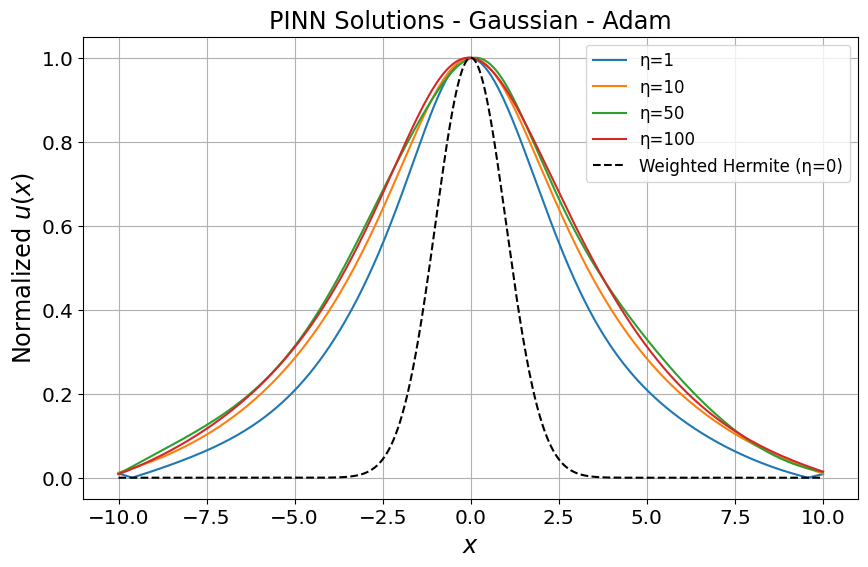

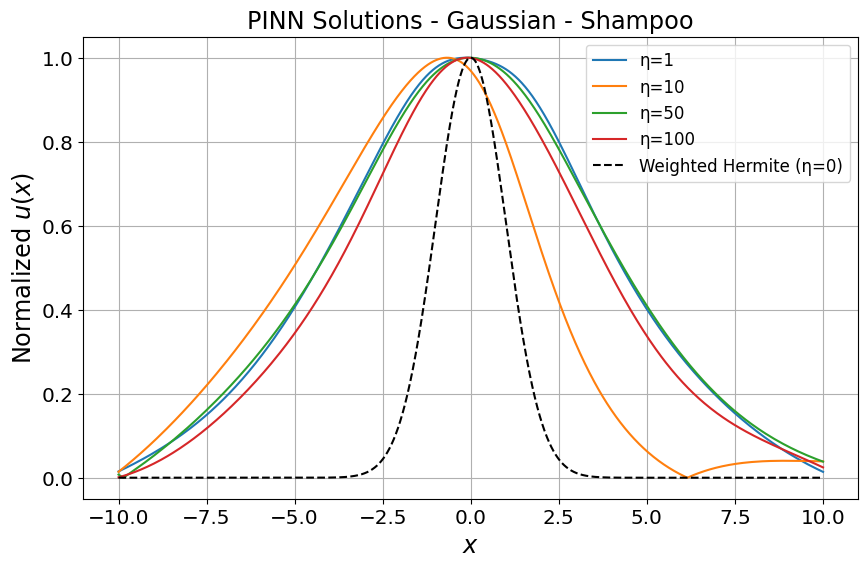

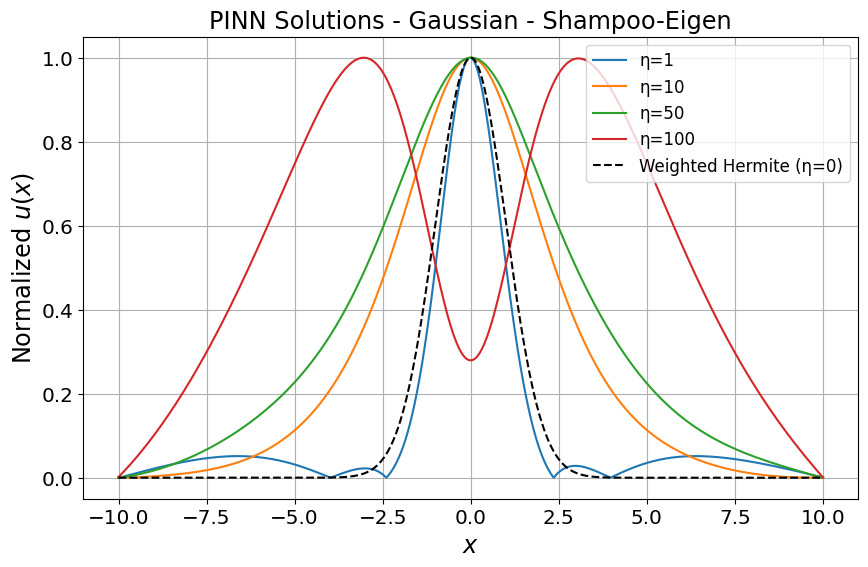

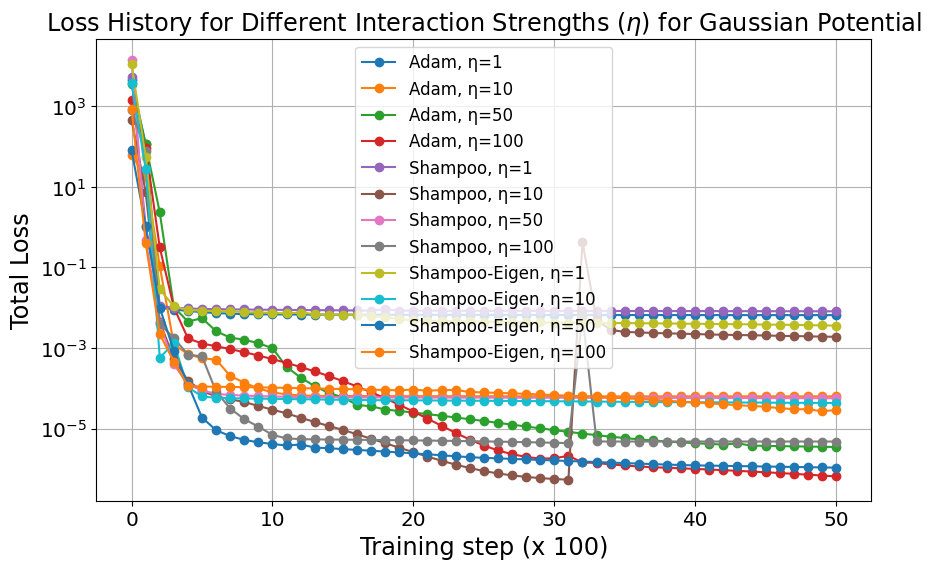

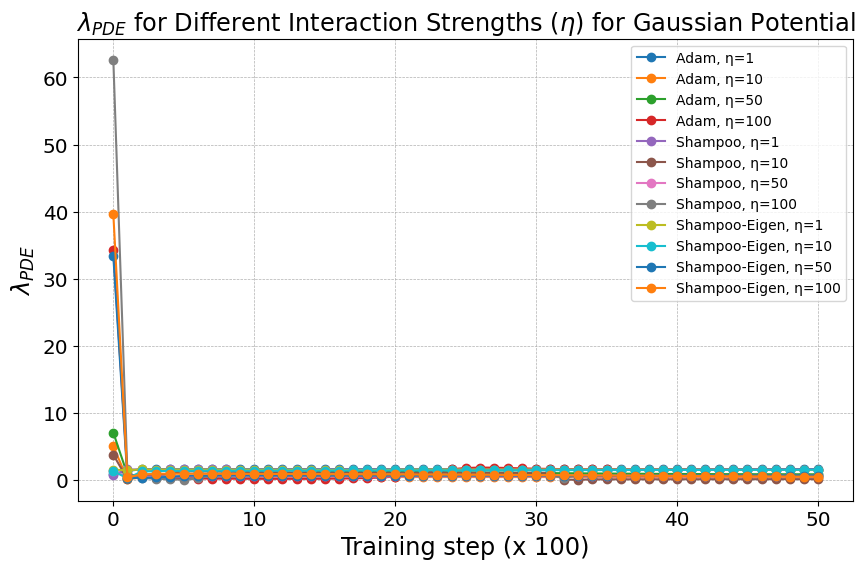

Training with Adam optimizer...
[Adam] Epoch [0/5001]: η = 1, λ_PDE = 22.115181,  Loss: 214.173431, Data Loss = 0.022542, Riesz Loss = 0.188556, PDE Loss = 8.013958, Norm Loss = 21.253103, Sym Loss = 0.060616, Adaptive Weights: [1.0, 1.0, 1.0, 1.0, 1.0]
[Adam] Epoch [1000/5001]: η = 1, λ_PDE = 1.167547,  Loss: 0.003231, Data Loss = 0.000003, Riesz Loss = 0.030954, PDE Loss = 0.017204, Norm Loss = 0.000000, Sym Loss = 0.000007, Adaptive Weights: [0.9526779651641846, 0.9581062197685242, 0.959018349647522, 0.9643966555595398, 0.9674450159072876]
[Adam] Epoch [2000/5001]: η = 1, λ_PDE = 1.167804,  Loss: 0.003135, Data Loss = 0.000003, Riesz Loss = 0.030987, PDE Loss = 0.016756, Norm Loss = 0.000000, Sym Loss = 0.000003, Adaptive Weights: [0.9518091678619385, 0.9536006450653076, 0.9550902247428894, 0.9643966555595398, 0.9668112397193909]
[Adam] Epoch [3000/5001]: η = 1, λ_PDE = 1.168338,  Loss: 0.003046, Data Loss = 0.000002, Riesz Loss = 0.031038, PDE Loss = 0.016224, Norm Loss = 0.000000,

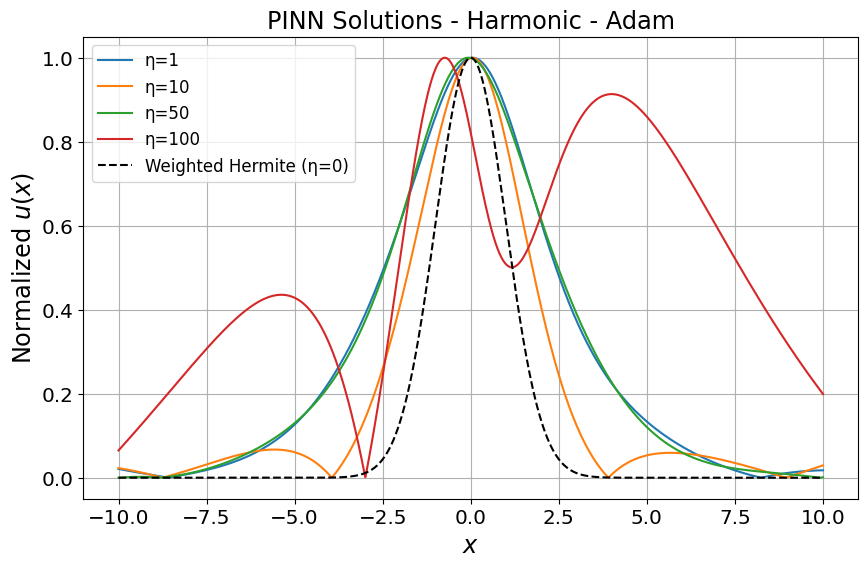

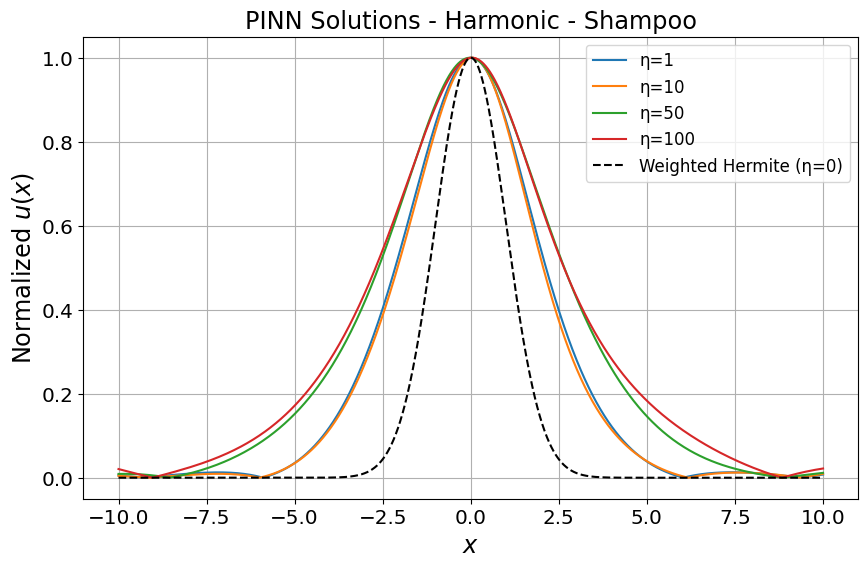

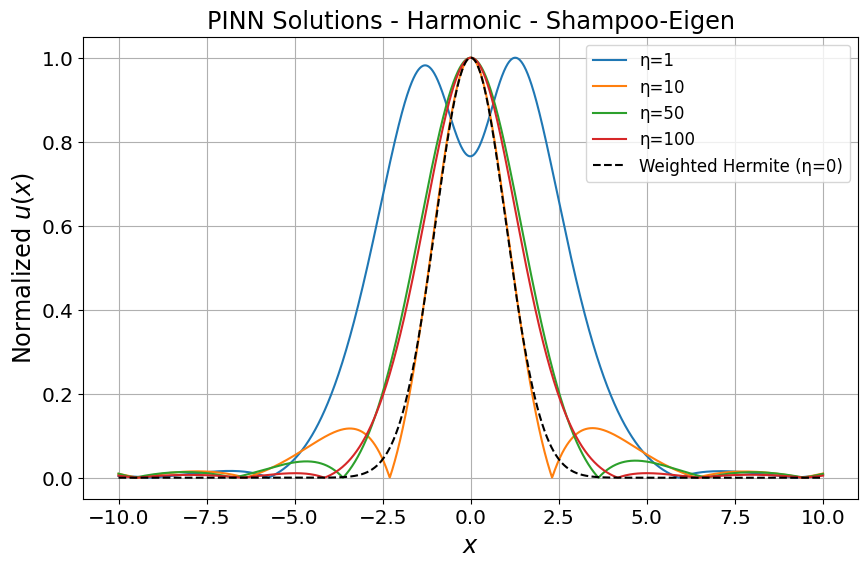

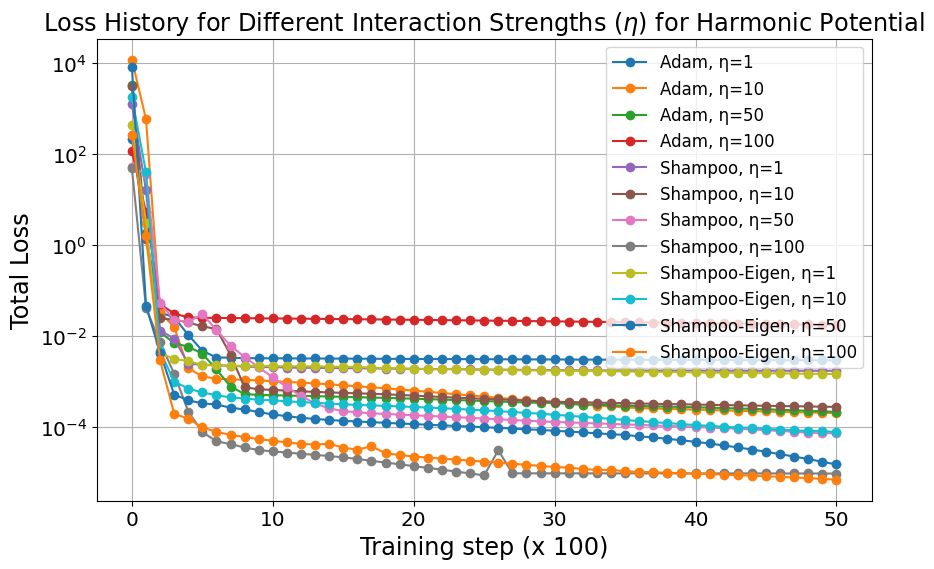

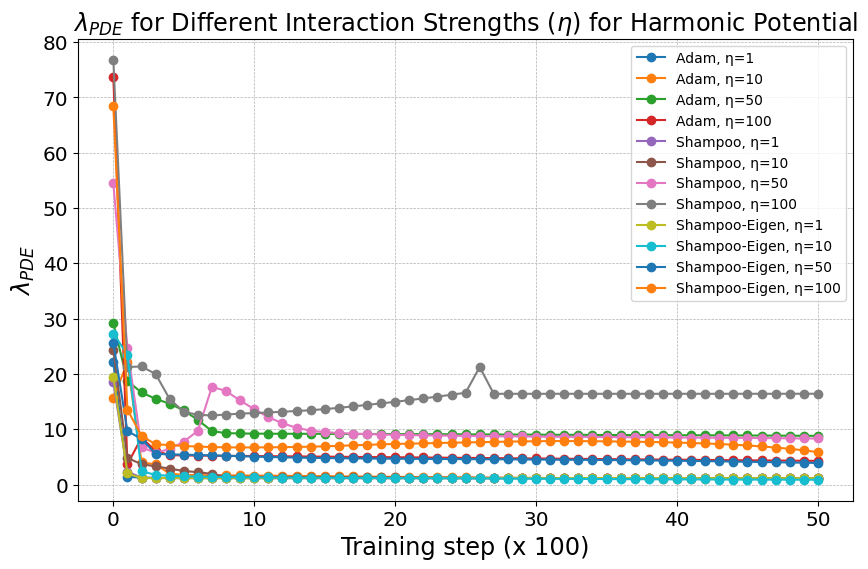

Training with Adam optimizer...
[Adam] Epoch [0/5001]: η = 1, λ_PDE = 0.934884,  Loss: 1161.484497, Data Loss = 0.099122, Riesz Loss = 0.051169, PDE Loss = 0.087957, Norm Loss = 115.771568, Sym Loss = 0.276629, Adaptive Weights: [1.0, 1.0, 1.0, 1.0, 1.0]
[Adam] Epoch [1000/5001]: η = 1, λ_PDE = 1.532751,  Loss: 0.006419, Data Loss = 0.000000, Riesz Loss = 0.027790, PDE Loss = 0.054086, Norm Loss = 0.000000, Sym Loss = 0.000002, Adaptive Weights: [0.9396398663520813, 0.9429062604904175, 0.941925585269928, 0.9542558193206787, 0.945746123790741]
[Adam] Epoch [2000/5001]: η = 1, λ_PDE = 1.530931,  Loss: 0.006314, Data Loss = 0.000000, Riesz Loss = 0.027646, PDE Loss = 0.053882, Norm Loss = 0.000000, Sym Loss = 0.000001, Adaptive Weights: [0.9395237565040588, 0.9315433502197266, 0.9305609464645386, 0.954251766204834, 0.9443954229354858]
[Adam] Epoch [3000/5001]: η = 1, λ_PDE = 1.528473,  Loss: 0.006239, Data Loss = 0.000000, Riesz Loss = 0.027491, PDE Loss = 0.053668, Norm Loss = 0.000000, 

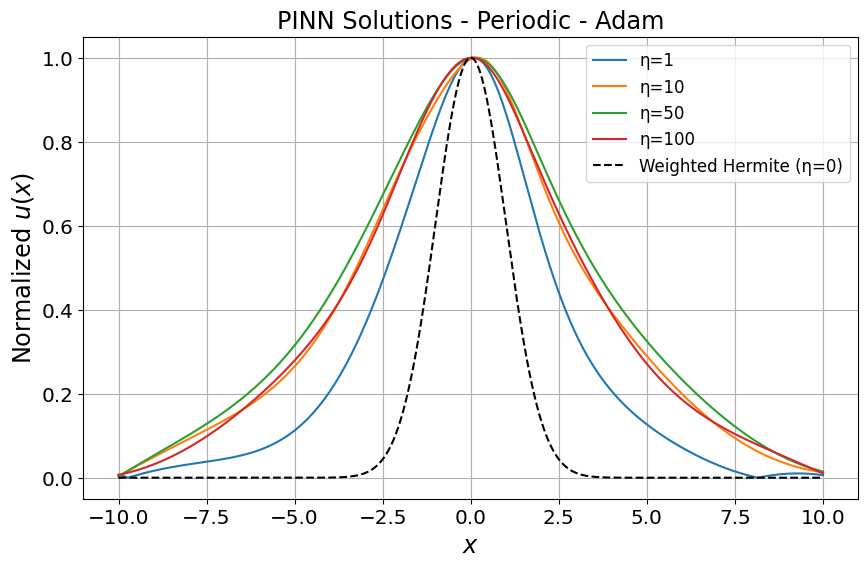

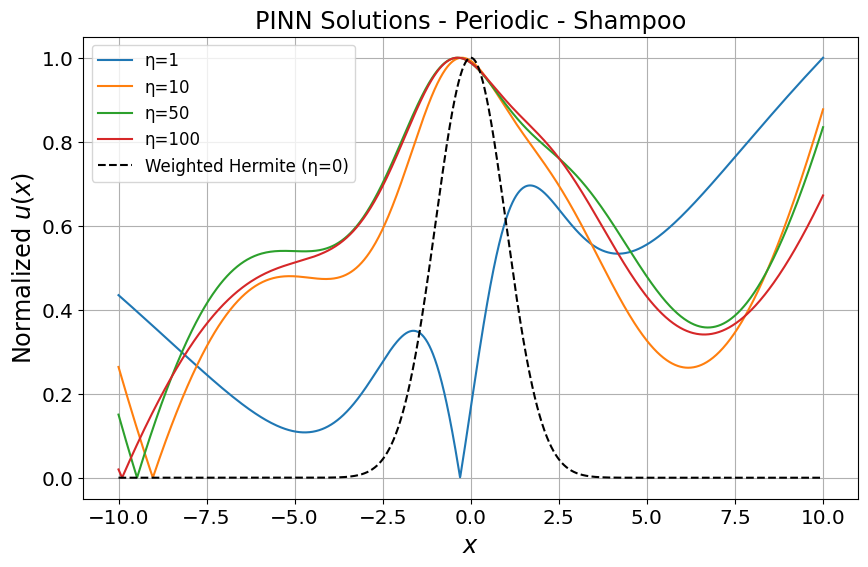

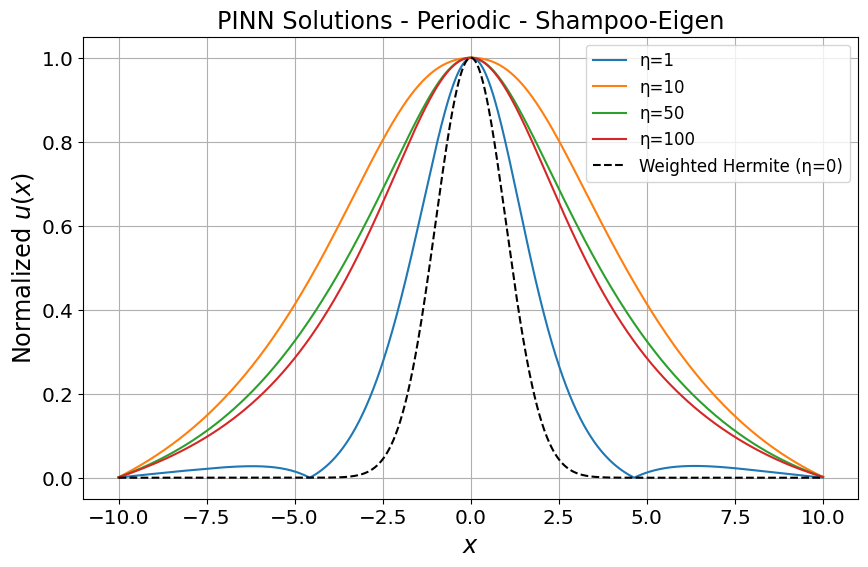

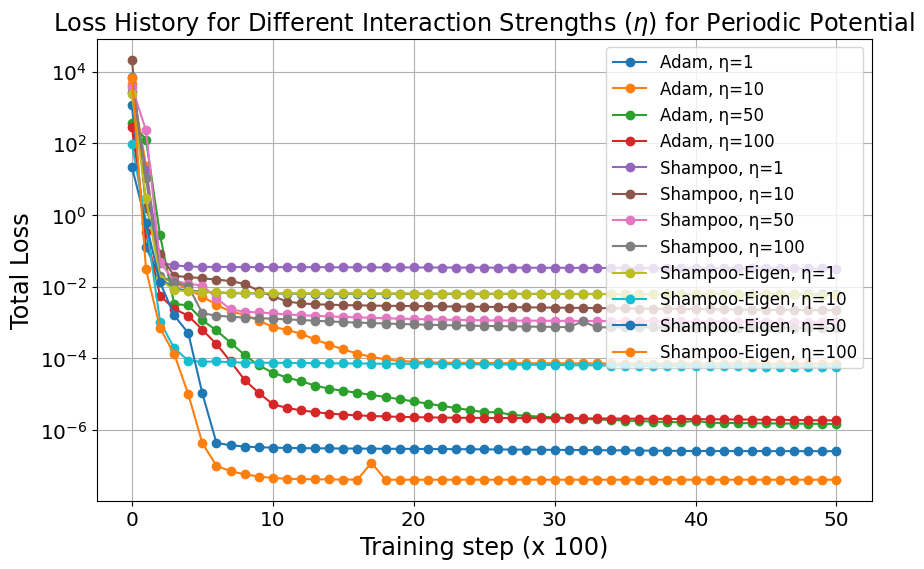

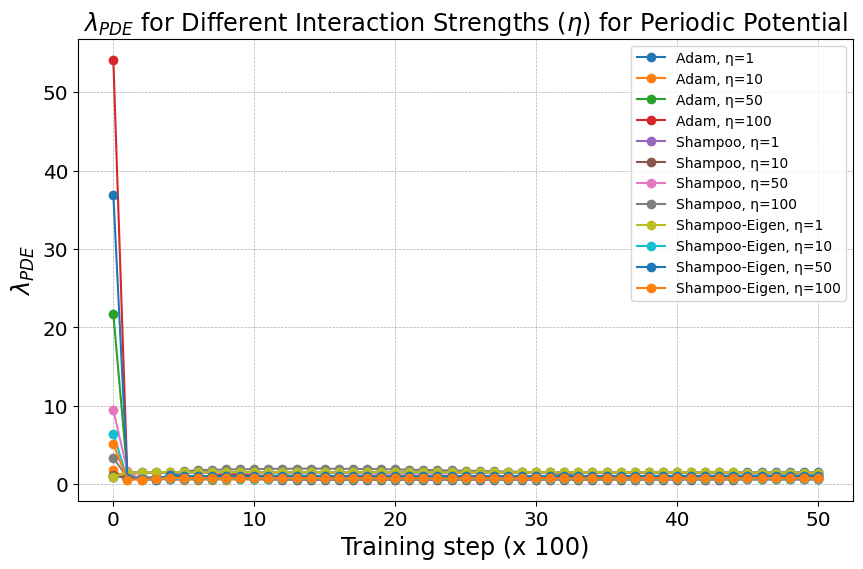

In [14]:
potential_types = ['gaussian', 'harmonic', 'periodic']
# potential_types = ['harmonic']

# Optimizers to compare
optimizer_names = ["Adam", "Shampoo", "Shampoo-Eigen"]

# Store results for plotting
all_loss_histories = {}
all_lambda_pde_histories = {}
models = {eta: {} for eta in etas}  # Store models for all η and optimizers

# Loop through each potential type
for potential_type in potential_types:

    for optimizer_name in optimizer_names:
        print(f"Training with {optimizer_name} optimizer...")

        # Store results for each optimizer separately
        prev_model = None
        loss_histories = {}
        lambda_pde_histories = {}

        for eta in etas:
            model_save_path = f"trained_model_eta_{eta}_{optimizer_name}.pth"
            model, loss_history, lambda_pde_history = train_and_save_pinn(X, N_u=N_u, N_f=N_f, layers=layers, eta=eta,
                                                                          epochs=epochs, lb=lb, ub=ub,
                                                                          weights=weights, model_save_path=model_save_path,
                                                                          potential_type=potential_type, prev_model=prev_model,
                                                                          optimizer_name=optimizer_name)
            prev_model = model  # Store the trained model for the next iteration

            # Store models by eta and optimizer
            models[eta][optimizer_name] = model

            # Store loss and λ_PDE history under each eta for this optimizer
            if potential_type not in all_loss_histories:
                all_loss_histories[potential_type] = {}
            if potential_type not in all_lambda_pde_histories:
                all_lambda_pde_histories[potential_type] = {}

            all_loss_histories[potential_type].setdefault(eta, {})[optimizer_name] = loss_history
            all_lambda_pde_histories[potential_type].setdefault(eta, {})[optimizer_name] = lambda_pde_history

    # Predict and plot the solutions for each optimizer separately
    predict_and_plot(models, etas, optimizer_names, X_test, save_path='plots/predicted_solutions_{potential_type}.png',
                     potential_type=potential_type, prev_prediction=prev_model)

    # Plot the loss history for all etas
    plot_loss_history(all_loss_histories[potential_type], etas, optimizer_names,
                      save_path='plots/loss_history_{potential_type}.png', potential_type=potential_type)

    # Plot lambda_pde history for all etas
    plot_lambda_pde(all_lambda_pde_histories[potential_type], etas, optimizer_names,
                    save_path=f'plots/lambda_pde_{potential_type}.png', potential_type=potential_type)